# Import libraries

In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

### Other dependencies ###
from PIL import Image
from sklearn.preprocessing import OneHotEncoder

### Tensorflow dependencies ###
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import applications
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy

### Some constants ###
input_dim = (48, 48, 3)
epochs = 3000
batch_size = 16
validation_size = 0.2

pnet_weights = 'weights/pnet.weights.hdf5'
rnet_weights = 'weights/rnet.weights.hdf5'
train_dir = "/home/minhhieu/Desktop/Hieu/datasets/RoadSignDetection/images"
test_dir = "/home/minhhieu/Desktop/Hieu/datasets/GTSDB/TestIJCNN2013/TestIJCNN2013Download"

# Load and explore dataset

[INFO] From images to ground truth ... 
[INFO] Converting to raw dataset ... 
[INFO] 1244 samples loaded ... 


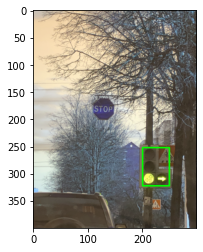

In [2]:
def load_raw_dataset(dataset_dir, gt_file, delimiter=';', max_n_samples=5000):
    '''
        This function will take in a dataset directory with ppm images (according to the DTSDB dataset)
        then it will return a list where each element is a list of 3 items. First item is the image, the
        second item is the bounding box and the last is the class ID.
        
        Params :
            @dataset_dir : Dataset directory.
            @gt_file : The file that consists of ground truth annotation in the format
            <img_pth>;<left>;<top>;<right>;<bottom>;<class_idx>.
            @delimiter : The separator of each item in each line of the ground truth file
            
        Returns :
            raw_dataset : list of elements [<cv2_img>, <gt_bbox>, <class_idx>]
    '''
    gt_abs_path = os.path.join(dataset_dir, gt_file)
    lines = open(gt_abs_path, 'r').readlines()
    
    print('[INFO] From images to ground truth ... ')
    images_to_gt = [[x.strip().split(delimiter)[0],   # Image path
                     x.strip().split(delimiter)[1:5], # Bbox regression ground truth
                     x.strip().split(delimiter)[5]]   # The class index
                    for x in lines]
    
    print('[INFO] Converting to raw dataset ... ')
    raw_dataset = [[cv2.imread(os.path.join(dataset_dir, x[0])),
                    np.array(x[1]).astype('int'),
                    int(x[2])]
                  for x in images_to_gt[:max_n_samples]]
    
    print(f'[INFO] {len(raw_dataset)} samples loaded ... ')
    
    return raw_dataset
    
raw_dataset = load_raw_dataset(train_dir, 'gt.txt')

### Visualize sample data ###
img = raw_dataset[1][0].copy()
bbox = raw_dataset[1][1]
x1, y1, x2, y2 = bbox
img = cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
plt.imshow(img)
plt.show()

### Generating negative samples (samples without traffic signs)

[INFO] 1244 negative samples generated ... 


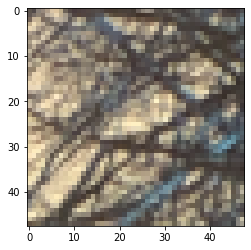

In [3]:
def generate_neg_samples(raw_dataset, crop_size=(48, 48)):
    '''
        This function will generate croppings of fixed size without any traffic sign
        and return those croppings with dummy bbox ground truth
        
        Params:
            @raw_dataset : The raw dataset formated similarly above
            @crop_size : The fixed cropping size
            
        Return:
            neg_samples : A list in format [<crop_img>,<dummy_bbox>,0]
    '''
    neg_samples = []
    for img, bbox, class_id in raw_dataset:
        height, width = img.shape[:2]
        x1, y1, x2, y2 = bbox
        range_x = ((0, max(x1 - crop_size[0], 0)), (min(x2 + crop_size[0], width), width))
        range_y = ((0, max(y1 - crop_size[1], 0)), (min(y2 + crop_size[1], height), height))
        
        ### Generate a random x,y coordinates ###
        x = random.choice([random.randint(range_x[0][0], range_x[0][1]), 
                           random.randint(range_x[1][0], range_x[1][1])])
        y = random.choice([random.randint(range_y[0][0], range_y[0][1]), 
                           random.randint(range_y[1][0], range_y[1][1])])
        
        # regenerate if cropping does not satisfy the size requirements
        while(width - x < crop_size[0] or height - y < crop_size[1]):
            x = random.choice([random.randint(range_x[0][0], range_x[0][1]), 
                           random.randint(range_x[1][0], range_x[1][1])])
            y = random.choice([random.randint(range_y[0][0], range_y[0][1]), 
                           random.randint(range_y[1][0], range_y[1][1])])
        
        crop = img[y:y+crop_size[1], x:x+crop_size[0]]
        neg_samples.append([crop, np.array([0,0,0,0]), 0])
        
    print(f'[INFO] {len(neg_samples)} negative samples generated ... ')
    return np.array(neg_samples)

neg_samples = generate_neg_samples(raw_dataset, crop_size=(48,48))
plt.imshow(neg_samples[1][0].copy())
plt.show()

### Generate positive samples (samles with traffic signs)

[INFO] 1244 positive samples generated ... 


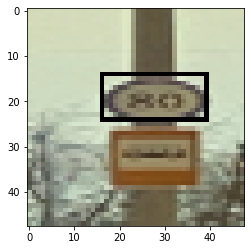

In [4]:
def generate_pos_samples(raw_dataset, pad_range=(10, 100), img_size=48):
    '''
        This function will generate croppings with traffic signs
        and return those croppings with bbox ground truth
        
        Params:
            @raw_dataset : The raw dataset formated similarly above
            @pad_range : The pad range around the ground truth bounding box
            
        Return:
            pos_samples : A list in format [<crop_img>,<bbox>,1]
    '''
    pos_samples = []
    for img, bbox, class_id in raw_dataset:
        height, width = img.shape[:2]
        x1, y1, x2, y2 = bbox
        pad_x1 = min(x1, random.randint(pad_range[0], pad_range[1]))
        pad_x2 = min(width - x2, random.randint(pad_range[0], pad_range[1]))
        pad_y1 = min(y1, random.randint(pad_range[0], pad_range[1]))
        pad_y2 = min(height - y2, random.randint(pad_range[0], pad_range[1]))
        
        crop = img[y1 - pad_y1:y2 + pad_y2, x1 - pad_x1:x2 + pad_x2]
        h, w = crop.shape[:2]
        
        gt = np.array([pad_x1, pad_y1, pad_x1 + x2 - x1, pad_y1 + y2 - y1])
        # gt[2] = gt[2] - gt[0] # Calculates width
        # gt[3] = gt[3] - gt[1] # Calculates height
        gt = np.multiply(gt, np.array([1/w, 1/h, 1/w, 1/h])).astype('float32')
        
        crop = cv2.resize(crop, (img_size, img_size))
        pos_samples.append([crop, gt, 1])
        
    print(f'[INFO] {len(pos_samples)} positive samples generated ... ')
    return np.array(pos_samples)

pos_samples = generate_pos_samples(raw_dataset, pad_range=(5, 50), img_size=48)

img, gt, label = pos_samples[6]
img = img.copy()
h, w = img.shape[:2]
x1, y1, x2, y2 = np.multiply(gt, np.array([w,h,w,h])).astype('int')

img = cv2.rectangle(img, (x1, y1), (x2, y2), 2)
plt.imshow(img)
plt.show()

### Combine negative and positive samples to form training dataset

In [5]:
# Concatenate two groups and shuffle
train_dataset = np.concatenate([pos_samples, neg_samples])
np.random.shuffle(train_dataset)

images = np.array([x[0] for x in train_dataset])
bboxes = np.array([x[1] for x in train_dataset])
labels = OneHotEncoder().fit_transform(train_dataset[:,2].reshape(-1, 1)).toarray()

bboxes = bboxes.reshape(-1, 1, 1, 4)
labels = labels.reshape(-1, 1, 1, 2)

print(images.shape)
images = ((images - 127.5) / 127.5).astype('float32')
bboxes = bboxes.astype('float32')
labels = labels.astype('float32')

dataset_size = images.shape[0]
train_size = int(dataset_size * (1 - validation_size))

train_images = images[:train_size]
train_bboxes = bboxes[:train_size]
train_labels = labels[:train_size]

val_images = images[train_size:]
val_bboxes = bboxes[train_size:]
val_labels = labels[train_size:]

print(val_bboxes[:1])

(2488, 48, 48, 3)
[[[[0.22797927 0.05649718 0.8601036  0.7288136 ]]]]


# Implement R-Net architecture

In [6]:
def build_rnet_model(batch_norm=True, dropout=False):
    inputs = Input(shape=(48, 48, 3))
    
    r_layer = Conv2D(10, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(inputs)
    r_layer = PReLU(shared_axes=[1, 2])(r_layer)
    if(batch_norm) : r_layer = BatchNormalization()(r_layer)
    r_layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(r_layer)

    r_layer = Conv2D(10, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(r_layer)
    r_layer = PReLU(shared_axes=[1, 2])(r_layer)
    if(batch_norm) : r_layer = BatchNormalization()(r_layer)
    
    r_layer = Conv2D(10, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(r_layer)
    r_layer = PReLU(shared_axes=[1, 2])(r_layer)
    if(batch_norm) : r_layer = BatchNormalization()(r_layer)
    r_layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(r_layer)
    
    r_layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(r_layer)
    r_layer = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(r_layer)
    r_layer = PReLU(shared_axes=[1, 2])(r_layer)
    if(batch_norm) : r_layer = BatchNormalization()(r_layer)

    r_layer = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(r_layer)
    r_layer = PReLU(shared_axes=[1, 2])(r_layer)
    if(dropout) : r_layer = Dropout(0.5)(r_layer)

    r_layer_out1 = Conv2D(32, kernel_size=(1,1), strides=(1,1))(r_layer)
    r_layer_out1 = Conv2D(2, kernel_size=(1,1), strides=(1,1))(r_layer_out1)
    r_layer_out1 = Softmax(axis=3, name='probability')(r_layer_out1)

    r_layer_out2 = Conv2D(4, kernel_size=(1, 1), strides=(1, 1), activation='sigmoid', name='bbox_regression')(r_layer)

    r_net = Model(inputs, [r_layer_out1, r_layer_out2], name='R-Net')

    return r_net

rnet = build_rnet_model(batch_norm=True, dropout=True)
print(rnet.summary())

def build_pnet_model(batch_norm=True, dropout=False):
    inputs = Input(shape=(None, None, 3))
    
    p_layer = Conv2D(10, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(inputs)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
    if(batch_norm) : p_layer = BatchNormalization()(p_layer)
    p_layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(p_layer)

    p_layer = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
    if(batch_norm) : p_layer = BatchNormalization()(p_layer)

    p_layer = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
    if(dropout) : p_layer = Dropout(0.5)(p_layer)

    p_layer_out1 = Conv2D(2, kernel_size=(1, 1), strides=(1, 1))(p_layer)
    p_layer_out1 = Softmax(axis=3, name='probability')(p_layer_out1)

    p_layer_out2 = Conv2D(4, kernel_size=(1, 1), strides=(1, 1), activation='sigmoid', name='bbox_regression')(p_layer)

    p_net = Model(inputs, [p_layer_out1, p_layer_out2], name='P-Net')

    return p_net

pnet = build_pnet_model(batch_norm=False, dropout=True)
rnet = build_rnet_model( batch_norm=True, dropout=True)
# rnet = build_rnet_inception_backbone(input_shape=input_dim)
print(rnet.summary())

Model: "R-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 10)   280         input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 46, 46, 10)   10          conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 46, 10)   40          p_re_lu[0][0]                    
______________________________________________________________________________________________

# Start training

In [7]:
def get_custom_bbox_regression_loss(reduction='sum', batch_size=16):
    def custom_bbox_regression_loss(y_true, y_pred, reduction=reduction, batch_size=batch_size):
        '''
            This function customize bounding box regression loss by taking sum of the 
            l2 loss of the top left corner coordinates and the log of the ration between
            predicted and ground truth width/height.

            Params :
                - y_true : ground truth bounding boxes.
                - y_pred : predicted bounding boxes.

            Return :
                - loss : custom bbox regression loss
        '''
        def get_mask(batch_size, col_id=0):
            a = np.zeros((batch_size, 4), dtype=np.float32)
            a[:, col_id] = 1
            a = tf.convert_to_tensor(a)

            return a

        y_true = tf.reshape(y_true, [-1, 4])
        y_pred = tf.reshape(y_pred, [-1, 4])

        if(reduction == 'sum'):
            reduction = K.sum
        elif(reduction == 'mean'):
            reduction = K.mean
        else:
            reduction = K.mean

        if(isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray)):
            x_gt, y_gt, w_gt, h_gt = y_true[:,0], y_true[:,1], y_true[:,2], y_true[:,3]
            x_pr, y_pr, w_pr, h_pr = y_pred[:,0], y_pred[:,1], y_pred[:,2], y_pred[:,3]
        else:
            x_gt = K.sum(tf.multiply(y_true, get_mask(batch_size, col_id=0)), axis=1, keepdims=True) 
            y_gt = K.sum(tf.multiply(y_true, get_mask(batch_size, col_id=1)), axis=1, keepdims=True) 
            w_gt = K.sum(tf.multiply(y_true, get_mask(batch_size, col_id=2)), axis=1, keepdims=True) 
            h_gt = K.sum(tf.multiply(y_true, get_mask(batch_size, col_id=3)), axis=1, keepdims=True) 

            x_pr = K.sum(tf.multiply(y_pred, get_mask(batch_size, col_id=0)), axis=1, keepdims=True) 
            y_pr = K.sum(tf.multiply(y_pred, get_mask(batch_size, col_id=1)), axis=1, keepdims=True) 
            w_pr = K.sum(tf.multiply(y_pred, get_mask(batch_size, col_id=2)), axis=1, keepdims=True) 
            h_pr = K.sum(tf.multiply(y_pred, get_mask(batch_size, col_id=3)), axis=1, keepdims=True) 

        l2_loss = reduction((x_gt - x_pr) ** 2) + reduction((y_gt - y_pr) ** 2)
        log_loss = reduction(K.binary_crossentropy(w_gt, w_pr)) + reduction(K.binary_crossentropy(h_gt, h_pr))
        # log_loss = reduction((K.sqrt(w_gt) - K.sqrt(w_pr)) ** 2) + reduction((K.sqrt(h_gt) - K.sqrt(h_pr))**2)
        loss = l2_loss + log_loss

        return loss

    return custom_bbox_regression_loss


# # Start training
losses_1 = {
    'probability' : BinaryCrossentropy(),
    'bbox_regression' : get_custom_bbox_regression_loss(batch_size=batch_size, reduction='sum')
}

losses_2 = {
    'probability' : BinaryCrossentropy(),
    'bbox_regression' : get_custom_bbox_regression_loss(batch_size=batch_size, reduction='mean') 
}
 
loss_weights = {
    'probability' : 1.0,
    'bbox_regression' : 0.5
}

y_train = {
    'probability' : train_labels,
    'bbox_regression' : train_bboxes
}

y_val = {
    'probability' : val_labels,
    'bbox_regression' : val_bboxes
}
 
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, y_train))
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, y_val))
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)


if(os.path.exists(rnet_weights)):
    print('[INFO] Loading R-Net pretrained weights ...')
    rnet.load_weights(rnet_weights)

[INFO] Loading R-Net pretrained weights ...


In [8]:
tensorboard = TensorBoard(log_dir="./logs")
checkpoint = ModelCheckpoint(rnet_weights, save_weights_only=True)

### Schedule 1 ###
print('[INFO] Begining schedule #1 ... ')
rnet.compile(optimizer=Adam(lr=0.00001, amsgrad=True),
            loss=losses_1,
            loss_weights=loss_weights,
            metrics={'probability':'accuracy'})

history = rnet.fit(train_dataset, epochs=epochs//2, 
        batch_size=batch_size, 
        validation_data=val_dataset, validation_batch_size=batch_size, 
        callbacks=[tensorboard, checkpoint])

### Schedule  2 ###
print('[INFO] Begining schedule #2 ...')
rnet.compile(optimizer=Adam(lr=0.0000001, amsgrad=True),
            loss=losses_2,
            loss_weights=loss_weights,
            metrics={'probability':'accuracy'})

history = rnet.fit(train_dataset, initial_epoch=epochs//2,
        epochs=epochs , batch_size=batch_size, 
        validation_data=val_dataset, validation_batch_size=batch_size, 
        callbacks=[tensorboard, checkpoint])


[INFO] Begining schedule #1 ... 
Epoch 1/1500


ValueError: in user code:

    /home/minhhieu/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/minhhieu/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/minhhieu/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/minhhieu/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/minhhieu/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/minhhieu/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/minhhieu/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /home/minhhieu/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/minhhieu/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:385 call
        return self._run_internal_graph(
    /home/minhhieu/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/minhhieu/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/minhhieu/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer bbox_regression is incompatible with the layer: expected axis -1 of input shape to have value 72 but received input with shape [16, 8]


# Test P-Net proposals

In [8]:
def __nms(boxes, s, threshold, method):
    """
        Non Maximum Suppression.

        Params:
            @param boxes: np array with bounding boxes.
            @param threshold:
            @param method: NMS method to apply. Available values ('Min', 'Union')
        
        Return:
            pick : An array of indices selected.
    """
    if boxes.size == 0:
        return np.empty((0, 3))

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2] + x1
    y2 = boxes[:, 3] + y1

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    sorted_s = np.argsort(s)

    pick = np.zeros_like(s, dtype=np.int16)
    counter = 0
    while sorted_s.size > 0:
        i = sorted_s[-1]
        pick[counter] = i
        counter += 1
        idx = sorted_s[0:-1]

        xx1 = np.maximum(x1[i], x1[idx])
        yy1 = np.maximum(y1[i], y1[idx])
        xx2 = np.minimum(x2[i], x2[idx])
        yy2 = np.minimum(y2[i], y2[idx])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)

        inter = w * h

        if method == 'Min':
            o = inter / np.minimum(area[i], area[idx])
        else:
            o = inter / (area[i] + area[idx] - inter)

        sorted_s = sorted_s[np.where(o <= threshold)]

    pick = pick[0:counter]

    return pick

Model: "P-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, None, None, 1 280         input_2[0][0]                    
__________________________________________________________________________________________________
p_re_lu_5 (PReLU)               (None, None, None, 1 10          conv2d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, None, None, 1 0           p_re_lu_5[0][0]                  
______________________________________________________________________________________________

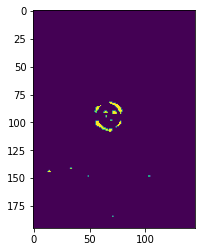

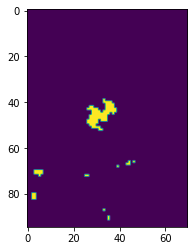

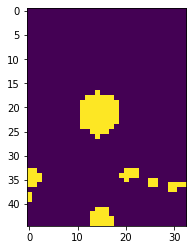

[INFO] Performing nms ... 


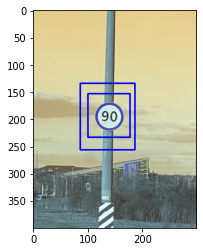

In [17]:
test_path = os.path.join(train_dir, 'road789.png')
threshold = 0.5
nms_threshold = 0.3
scale_factor = 2.0
min_img_size = 48

print(pnet.summary())
if(os.path.exists(pnet_weights)):
    print('[INFO] Loading P-Net pretrained weights ...')
    pnet.load_weights(pnet_weights)

raw_img = cv2.imread(test_path)
H, W = raw_img.shape[:2]

images = [raw_img]
current_h, current_w = raw_img.shape[:2]
while(current_h > min_img_size and current_w > min_img_size):
    current_h = int(current_h / scale_factor)
    current_w = int(current_w / scale_factor)
    
    if(current_w < min_img_size or current_h < min_img_size) : break
    
    image = cv2.resize(raw_img, (current_w, current_h))
    images.append(image)
    
boxes = []
for i, image in enumerate(images):
    if(i == 0): scale = 1
    else : scale = scale_factor ** i
        
    img = (image - 127.5) / 127.5
    height, width = image.shape[:2]

    predictions = pnet.predict(np.array([img]))
    features_shape = predictions[1][0].shape[:2]
    
    scale_w = width / features_shape[1]
    scale_h = height / features_shape[0]
    
    bboxes = predictions[1][0]
    raw_bboxes = bboxes
    confidence = predictions[0][0]

    ### Showing confidence map ###
    conf_map = confidence[:, :, 1]
    conf_map[conf_map > 0.8] = 255
    conf_map[conf_map <= 0.8] = 0
    conf_map = (conf_map * 255).astype(np.uint8)
    contours, hierarchy = cv2.findContours(conf_map, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        rect = cv2.boundingRect(contour)
        x, y, w, h = (rect * np.array([W/conf_map.shape[1],H/conf_map.shape[0],W/conf_map.shape[1],H/conf_map.shape[0] ])).astype(int)
        
        if(w * h < (W * H)/64): continue
        boxes.append([x,y,w,h])
        
    plt.imshow(conf_map)
    plt.show()
        
print('[INFO] Performing nms ... ')
pick = __nms(np.array(boxes), np.ones((len(boxes))), nms_threshold, 'Min')
crops = []
bboxes = []
padding = 0.2
for i in range(len(boxes)):
    x,y,w,h = boxes[i]
    x = max(0, x - int(w*padding))
    y = max(0, y - int(h*padding))
    w = min(raw_img.shape[1], w + 2*int(w*padding))
    h = min(raw_img.shape[0], h + 2*int(h*padding))
    
    crop = cv2.imread(test_path)[y:y+h, x:x+w]
    cv2.rectangle(raw_img, (x,y), (x+w, y+h), (0,0,255),2)
    
    crops.append(crop)
    bboxes.append((x,y,w,h))
    
plt.imshow(raw_img)
plt.show()

# Fine-tuning with R-Net

[0.99991715]


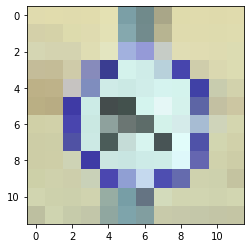

[0.9989561]


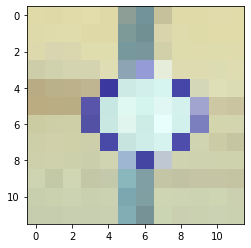

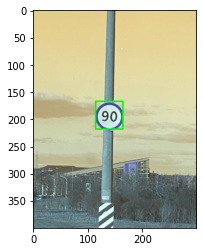

In [21]:
rnet_bboxes = []
rnet_confidences = []
for (crop, (x,y,w,h)) in zip(crops, bboxes):    
    H, W = crop.shape[:2]
    crop = (crop - 127.5) / 127.5
    crop_ = cv2.resize(crop, (12,12))
    prediction = pnet.predict(np.array([crop_]))
    
    img = (crop_.copy() * 127.5 + 127.5).astype('uint8')
    
    bbox = prediction[1][0][0][0]
    confidence = prediction[0][0][0][:,1]
    
    if(confidence < 0.5) : continue
    print(confidence)
    # x_, y_, w, h = (bbox * np.array([W, H, W, H])).astype(np.uint8)
    #x += x_
    #y += y_
    x1, y1,w ,h = (bbox * np.array([W, H, W, H])).astype(np.uint8)
    x+=x1
    y+=y1
        
    cv2.rectangle(img, (int(bbox[0] * 64), int(bbox[1] * 64)), (int((bbox[0]+bbox[2]) * 64), int((bbox[1]+bbox[3]) * 64)), (0,255,0))
    plt.imshow(img)
    plt.show()
    rnet_bboxes.append((x, y, w, h))
    rnet_confidences.append(confidence[0])
        
raw_img = cv2.imread(test_path)
pick = __nms(np.array(rnet_bboxes), rnet_confidences, nms_threshold, 'Min')

for i in pick:
    (x, y, w, h) = rnet_bboxes[i]
    cv2.rectangle(raw_img, (x, y), (x+w, y+h), (0,255,0), 2)

plt.imshow(raw_img)
plt.show()